In [79]:
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [81]:
df = pd.read_csv('C:/Users/User/Downloads/ds4a-secopII/SECOP_Electronicos_Cleaned.csv').drop(['NormalizedDelay','Unnamed: 0','Nombre Entidad','Dias Adicionados',
                                                                                                'Fecha de Inicio del Contrato', 'Fecha de Fin del Contrato'], axis=1)

In [82]:
df.columns

Index(['Departamento', 'Orden', 'Sector', 'Rama', 'Entidad Centralizada',
       'Estado Contrato', 'Tipo de Contrato', 'Modalidad de Contratacion',
       'Es Grupo', 'Es Pyme', 'Obligación Ambiental',
       'Obligaciones Postconsumo', 'Valor del Contrato',
       'Valor de pago adelantado', 'Valor Facturado',
       'Valor Pendiente de Pago', 'Valor Amortizado', 'EsPostConflicto',
       'Destino Gasto', 'PGN', 'SGP', 'SGR', 'RP_AGR', 'RP_NO_AGR', 'RC',
       'Delay', 'Days_to_end_of_year'],
      dtype='object')

In [83]:
print('The shape of the dataset result of data cleaning is : ' + str(df.shape))

The shape of the dataset result of data cleaning is : (1565450, 27)


In [84]:
#Convert the variables to its corresponding data type
cat_cols = ['Departamento', 'Orden', 'Sector', 'Rama','Entidad Centralizada', 'Estado Contrato', 'Tipo de Contrato', 'Modalidad de Contratacion',
            'Es Grupo','Es Pyme', 'Destino Gasto', 'EsPostConflicto','Obligaciones Postconsumo','Obligación Ambiental', 'Delay']
cat_values = {key:'category' for key in cat_cols}
df = df.astype(cat_values)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565450 entries, 0 to 1565449
Data columns (total 27 columns):
 #   Column                     Non-Null Count    Dtype   
---  ------                     --------------    -----   
 0   Departamento               1565450 non-null  category
 1   Orden                      1565450 non-null  category
 2   Sector                     1565450 non-null  category
 3   Rama                       1565450 non-null  category
 4   Entidad Centralizada       1565450 non-null  category
 5   Estado Contrato            1565450 non-null  category
 6   Tipo de Contrato           1565450 non-null  category
 7   Modalidad de Contratacion  1565450 non-null  category
 8   Es Grupo                   1565450 non-null  category
 9   Es Pyme                    1565450 non-null  category
 10  Obligación Ambiental       1565450 non-null  category
 11  Obligaciones Postconsumo   1565450 non-null  category
 12  Valor del Contrato         1565450 non-null  int64   
 1

# XGBoost

In [85]:
y = df['Delay'].astype('category')

X = df.drop(['Delay'], axis=1)

In [86]:
#Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

### Tuning XGBoost model

In [ ]:
# This cell was run in the Virtual Machine

# Creación de lista de valores para iterar sobre diferentes valores de n_estimators
estimator_range = range(0,50,1)

# Definición de lista para almacenar la exactitud (accuracy) promedio para cada valor de n_estimators
f1_scores = []

# Uso de un 5-fold cross-validation para cada valor de n_estimators
"""for estimator in estimator_range:
    
    clf = XGBClassifier(tree_method="hist", enable_categorical=True, learning_rate = (estimator*0.05))
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    f1_scores.append(metrics.f1_score(y_pred, y_test, average= 'macro'))"""

In [ ]:
# Gráfica del desempeño del modelo vs la cantidad de n_estimators
plt.plot(estimator_range, f1_scores)
plt.xlabel('Learning_Rate')
plt.ylabel('F1_Score')


## The optimal learning rate is 28 * 0.05
print('The best value of learning_rate is : ' + str(np.argmax(f1_scores)))

### Best Model - Learning Rate

In [88]:
# Importación y definición de modelo XGBClassifier

from xgboost import XGBClassifier
from sklearn import metrics 

clf = XGBClassifier(tree_method="gpu_hist", enable_categorical=True, learning_rate = (28*0.05))

# Entrenamiento (fit) y desempeño del modelo XGBClassifier
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print('\n')
print('El valor del F1_Score es: ' + str(metrics.f1_score(y_pred, y_test, average= 'macro')))

c:\ProgramData\Anaconda3\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[18:53:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\ProgramData\Anaconda3\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):




El valor del F1_Score es: 0.7565338309142804


# Random Forest

In [89]:
y = df['Delay'].astype('category')
X = df.drop(['Delay'], axis=1).copy()
X.columns

Index(['Departamento', 'Orden', 'Sector', 'Rama', 'Entidad Centralizada',
       'Estado Contrato', 'Tipo de Contrato', 'Modalidad de Contratacion',
       'Es Grupo', 'Es Pyme', 'Obligación Ambiental',
       'Obligaciones Postconsumo', 'Valor del Contrato',
       'Valor de pago adelantado', 'Valor Facturado',
       'Valor Pendiente de Pago', 'Valor Amortizado', 'EsPostConflicto',
       'Destino Gasto', 'PGN', 'SGP', 'SGR', 'RP_AGR', 'RP_NO_AGR', 'RC',
       'Days_to_end_of_year'],
      dtype='object')

In [90]:
X.Departamento = X.Departamento.cat.codes
X.Orden = X.Orden.cat.codes
X.Sector = X.Sector.cat.codes
X.Rama = X.Rama.cat.codes
X['Entidad Centralizada'] = X['Entidad Centralizada'].cat.codes
X['Estado Contrato'] = X['Estado Contrato'].cat.codes
X['Tipo de Contrato'] = X['Tipo de Contrato'].cat.codes
X['Modalidad de Contratacion'] = X['Modalidad de Contratacion'].cat.codes
X['Es Grupo'] = X['Es Grupo'].cat.codes
X['Es Pyme'] = X['Es Pyme'].cat.codes
X['Destino Gasto'] = X['Destino Gasto'].cat.codes
X['EsPostConflicto'] = X['EsPostConflicto'].cat.codes
X['Obligaciones Postconsumo'] = X['Obligaciones Postconsumo'].cat.codes
X['Obligación Ambiental'] = X['Obligación Ambiental'].cat.codes

In [91]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [92]:
from sklearn.ensemble import RandomForestClassifier

clf_Random_Forest = RandomForestClassifier(n_estimators=100, max_depth=6)

clf_Random_Forest.fit(X_train, y_train)
predicts_RF = clf_Random_Forest.fit(X_train, y_train).predict(X_test)

c:\ProgramData\Anaconda3\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


In [93]:
print('El valor del F1_Score es: ' + str(metrics.f1_score(y_pred, predicts_RF, average= 'macro')))

El valor del F1_Score es: 0.7565338309142804


### Tuning Random Forest Model

In [96]:
# Creación de lista de valores para iterar sobre diferentes valores de n_estimators
estimator_range = range(10, 310, 10)
max_range = range(5, X_train.shape[1], 1)

# Definición de lista para almacenar la exactitud (accuracy) promedio para cada valor de n_estimators
f1_scores = {(i,j):0 for i in estimator_range for j in max_range}

""" for estimator in estimator_range:
        for feature in max_range:
            clf = RandomForestClassifier(n_estimators=estimator, max_features=feature, n_jobs=-1)
            clf.fit(X_train, y_train)
            y_pred = clf.predict(X_test)
            f1_scores[estimator, feature] = metrics.f1_score(y_pred, y_test, average= 'macro')""" 

KeyboardInterrupt: 

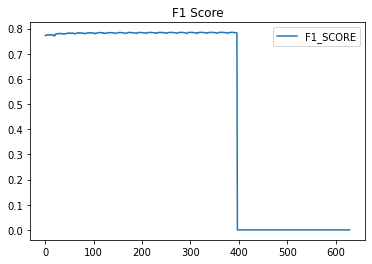

,0,1,F1_SCORE
342,170,11,0.785633
321,160,11,0.785622
364,180,12,0.785550
362,180,10,0.785508
345,170,14,0.785469
...,...,...,...
477,230,20,0.000000
478,230,21,0.000000
479,230,22,0.000000
480,230,23,0.000000


In [97]:
pl = (f1_scores.values())
pl = pd.DataFrame(pl).rename(columns={0: 'F1_SCORE'})

pa = (f1_scores.keys())
pa = pd.DataFrame(pa)

pd.DataFrame(pl).rename(columns={0: 'F1_SCORE'}).plot(kind='line', title='F1 Score')
plt.show()

sort_roc = pd.concat([pa, pl], axis=1)

sort_roc.sort_values(by=['F1_SCORE'], ascending=False)